In [1]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
import torch.nn.functional as F  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = '/kaggle/input/eurosat-dataset/EuroSAT'
train_dir = data_dir 

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [3]:
# # Load a pre-trained network 
# # model = models.vgg16(pretrained=True)
# # model.name = "vgg16"
# # model
# model = models.mobilenet_v2(pretrained=True)
# model.name='MobileNet'

In [4]:
# for param in model.parameters():
#     param.requires_grad = False

In [5]:
# num_features = model.classifier[1].out_features

In [6]:
# num_features

In [7]:
# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(25088, 4096, bias=True)),
#                           ('relu1', nn.ReLU()),
#                           ('dropout1', nn.Dropout(p=0.5)),
#                           ('fc2', nn.Linear(4096, 512, bias=True)),
#                           ('relu2', nn.ReLU()),
#                           ('dropout2', nn.Dropout(p=0.5)),
#                           ('fc3', nn.Linear(512, 256, bias=True)),
#                           ('relu3', nn.ReLU()),
#                           ('dropout3', nn.Dropout(p=0.5)),
#                           ('fc4',nn.Linear(256,4,bias=True)),
#                           ('output', nn.Softmax(dim=1))
#                         ]))
    
# # model.classifier = classifier
# classifier = nn.Sequential(
#     nn.AdaptiveAvgPool2d((1, 1)),
#     nn.Flatten(),
#     nn.Linear(1280, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 128),
#     nn.ReLU(),
#     nn.Linear(128, 4),
#     nn.Softmax(dim=1)
# )
# model.classifier=classifier

In [8]:
import torch.nn as nn
from torchvision.models import mobilenet_v2

class CustomMobileNetv2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()

        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, output_size),
            nn.LogSoftmax(1)
        )

    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True


In [9]:
model = CustomMobileNetv2(10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 91.7MB/s]


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
model.to(device)

CustomMobileNetv2(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [12]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)


epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [13]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [14]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [15]:
# def train(model, train_loader, valid_loader, optimizer, criterion, print_every, epochs):
#     print("Training process initializing .....\n")
    
#     model.train()

#     for e in range(epochs):
#         running_loss = 0
#         steps = 0
        
#         for ii, (inputs, labels) in enumerate(train_loader):
#             steps += 1
        
#             inputs, labels = inputs.to(device), labels.to(device)
        
#             optimizer.zero_grad()
        
#             # Forward and backward passes
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
        
#             running_loss += loss.item()
        
#             if steps % print_every == 0:
#                 model.eval()
#                 valid_loss, accuracy = validation(model, valid_loader, criterion)
            
#                 print("Epoch: {}/{} | ".format(e+1, epochs),
#                       "Training Loss: {:.4f} | ".format(running_loss/print_every),
#                       "Validation Loss: {:.4f} | ".format(valid_loss/len(valid_loader)),
#                       "Validation Accuracy: {:.4f}".format(accuracy/len(valid_loader)))
            
#                 running_loss = 0
#                 model.train()

#     print("\nTraining process is now complete!!")
#     return model



# # Define the optimizer and loss function
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# # Define print_every, epochs
# print_every = 10
# epochs = 10

# # Train the model
# trained_model = train(model, trainloader, validloader, optimizer, criterion, print_every, epochs)


In [16]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 0.8579 |  Validation Loss: 0.6581 |  Validation Accuracy: 0.7733
Epoch: 1/5 |  Training Loss: 0.6622 |  Validation Loss: 0.5994 |  Validation Accuracy: 0.7889
Epoch: 1/5 |  Training Loss: 0.6163 |  Validation Loss: 0.5655 |  Validation Accuracy: 0.8078
Epoch: 1/5 |  Training Loss: 0.6083 |  Validation Loss: 0.5031 |  Validation Accuracy: 0.8185
Epoch: 1/5 |  Training Loss: 0.5570 |  Validation Loss: 0.5000 |  Validation Accuracy: 0.8278
Epoch: 1/5 |  Training Loss: 0.5489 |  Validation Loss: 0.4582 |  Validation Accuracy: 0.8411
Epoch: 1/5 |  Training Loss: 0.5771 |  Validation Loss: 0.4472 |  Validation Accuracy: 0.8589
Epoch: 1/5 |  Training Loss: 0.5444 |  Validation Loss: 0.4979 |  Validation Accuracy: 0.8267
Epoch: 1/5 |  Training Loss: 0.5470 |  Validation Loss: 0.4613 |  Validation Accuracy: 0.8333
Epoch: 1/5 |  Training Loss: 0.5294 |  Validation Loss: 0.4465 |  Validation Accuracy: 0.8485
Epoch: 1/5 |  Training 

In [17]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [18]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  42.45575714111328
Accuracy achieved by the network on test images is: 86%


In [19]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


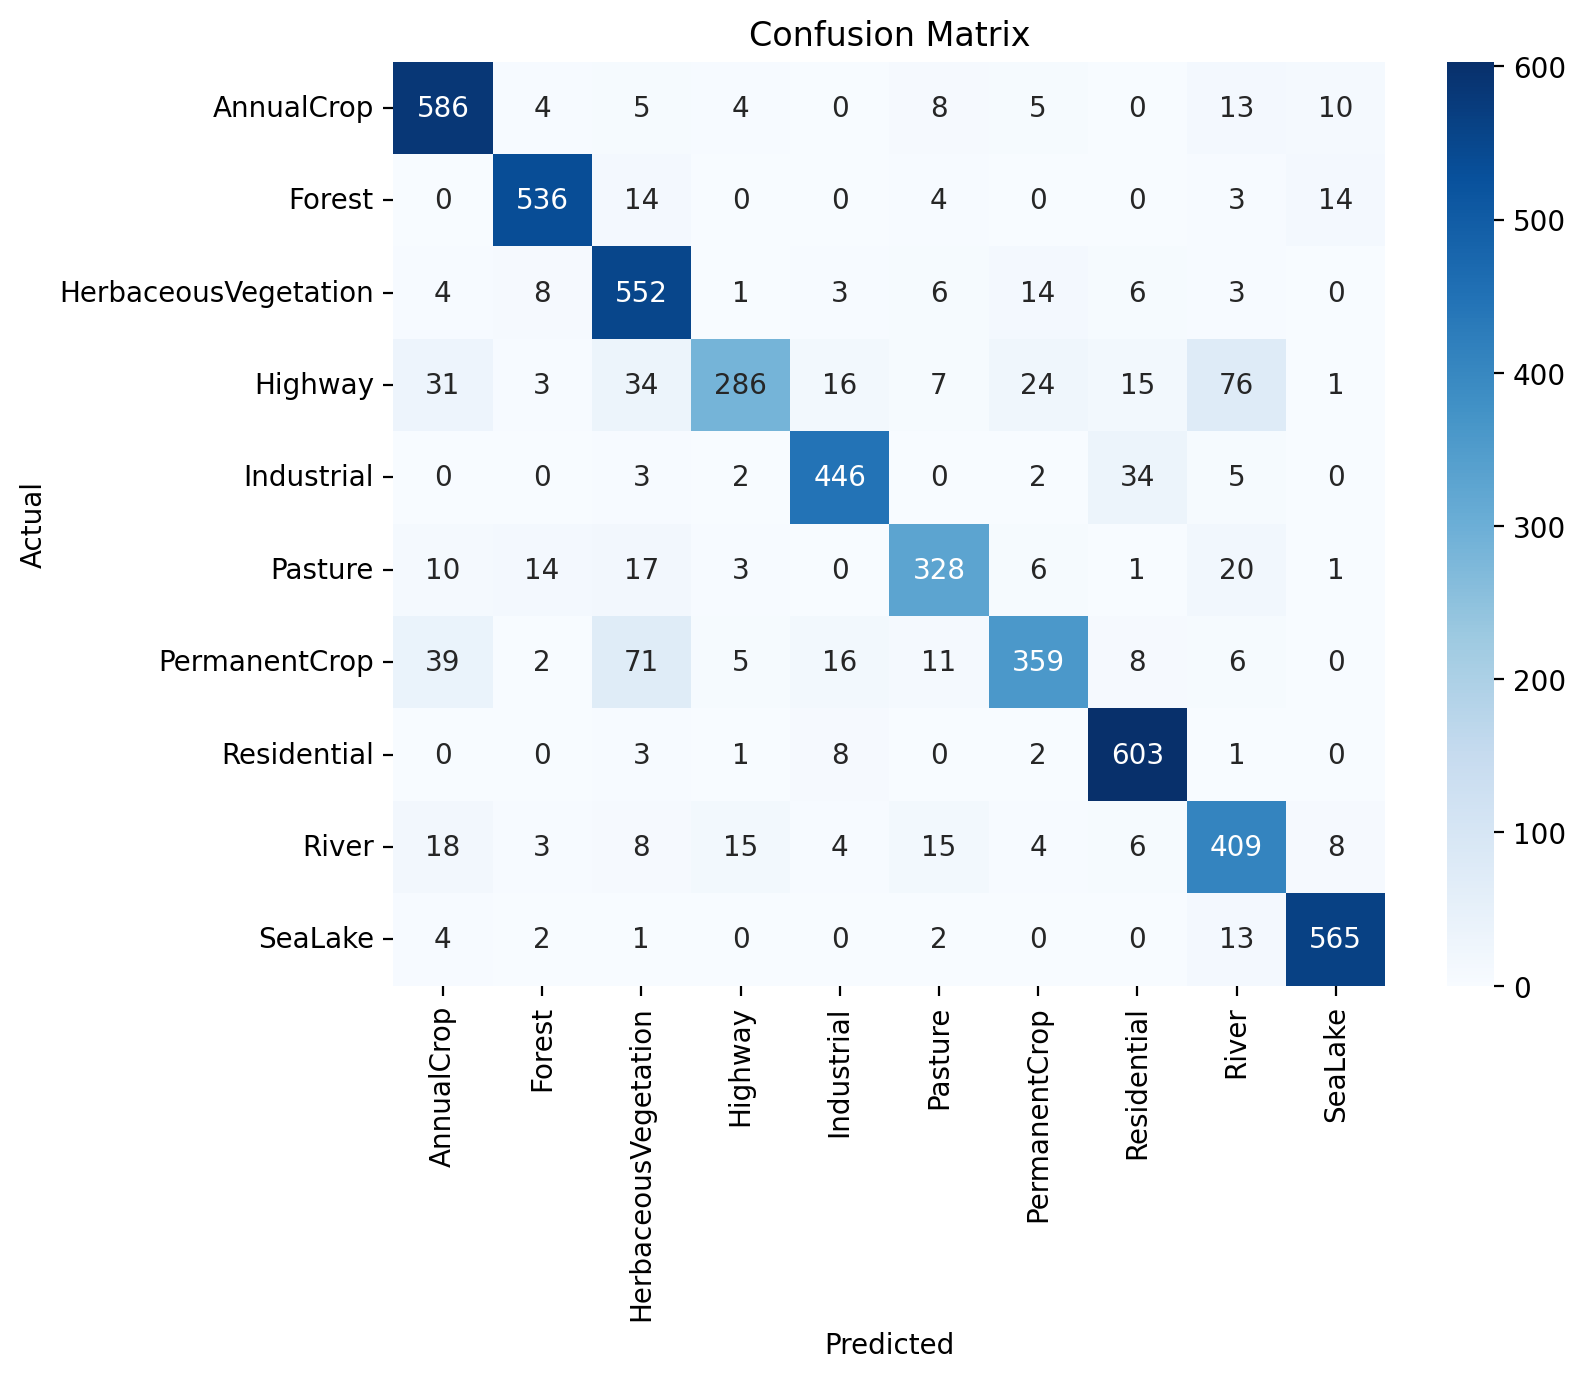

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       635
           1       0.94      0.94      0.94       571
           2       0.78      0.92      0.85       597
           3       0.90      0.58      0.71       493
           4       0.90      0.91      0.91       492
           5       0.86      0.82      0.84       400
           6       0.86      0.69      0.77       517
           7       0.90      0.98      0.93       618
           8       0.74      0.83      0.79       490
           9       0.94      0.96      0.95       587

    accuracy                           0.86      5400
   macro avg       0.87      0.86      0.86      5400
weighted avg       0.87      0.86      0.86      5400



In [20]:
metrics(labels_fp32,predictions_fp32)

In [21]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [22]:
print("Size of fp32 model:",end='')
print_model_size(model)

Size of fp32 model:16.52 MB


# Quantization

# FP-16

In [23]:
model_fp16 = copy.deepcopy(model)

In [24]:
model_fp16.half()
model_fp16.to(device)

CustomMobileNetv2(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [25]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [26]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  20.51145911216736
Accuracy achieved by the network on test images is: 85%


Confusion Matrix:


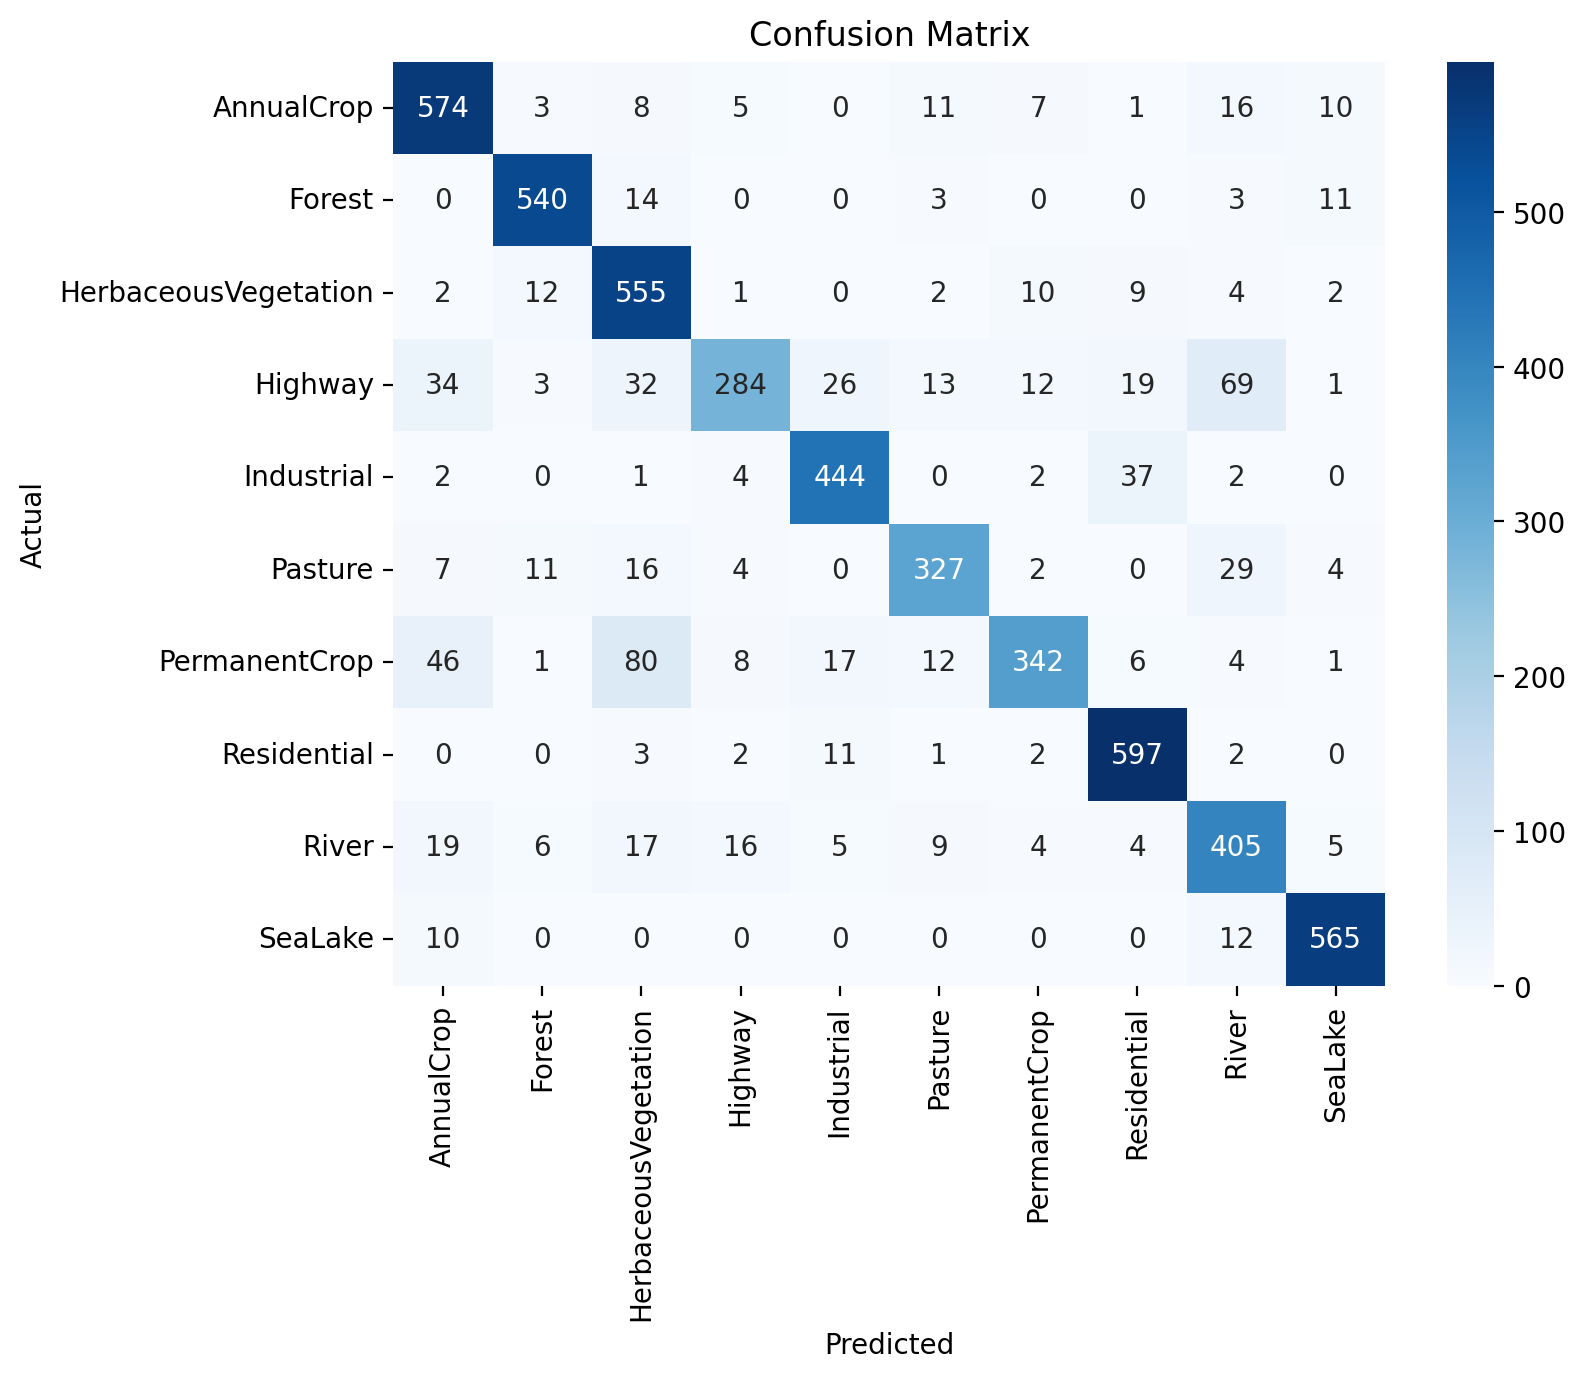

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       635
           1       0.94      0.95      0.94       571
           2       0.76      0.93      0.84       597
           3       0.88      0.58      0.70       493
           4       0.88      0.90      0.89       492
           5       0.87      0.82      0.84       400
           6       0.90      0.66      0.76       517
           7       0.89      0.97      0.92       618
           8       0.74      0.83      0.78       490
           9       0.94      0.96      0.95       587

    accuracy                           0.86      5400
   macro avg       0.86      0.85      0.85      5400
weighted avg       0.86      0.86      0.85      5400



In [27]:
metrics(labels_fp16,predictions_fp16)

## INT-8

In [28]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [29]:
model.to('cpu')

CustomMobileNetv2(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [30]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [31]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [32]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [33]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

OrderedDict([('mnet_features_0_0_input_scale_0', tensor(0.0346)),
             ('mnet_features_0_0_input_zero_point_0', tensor(51)),
             ('mnet_features_3_scale_0', tensor(0.0937)),
             ('mnet_features_3_zero_point_0', tensor(56)),
             ('mnet_features_5_scale_0', tensor(0.0620)),
             ('mnet_features_5_zero_point_0', tensor(62)),
             ('mnet_features_6_scale_0', tensor(0.0736)),
             ('mnet_features_6_zero_point_0', tensor(62)),
             ('mnet_features_8_scale_0', tensor(0.0449)),
             ('mnet_features_8_zero_point_0', tensor(65)),
             ('mnet_features_9_scale_0', tensor(0.0472)),
             ('mnet_features_9_zero_point_0', tensor(65)),
             ('mnet_features_10_scale_0', tensor(0.0679)),
             ('mnet_features_10_zero_point_0', tensor(69)),
             ('mnet_features_12_scale_0', tensor(0.0571)),
             ('mnet_features_12_zero_point_0', tensor(56)),
             ('mnet_features_13_scale_0', te

In [34]:
model_quantized_static

GraphModule(
  (mnet): Module(
    (features): Module(
      (0): Module(
        (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.0719936266541481, zero_point=44, padding=(1, 1))
        (2): ReLU6(inplace=True)
      )
      (1): Module(
        (conv): Module(
          (0): Module(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.20127829909324646, zero_point=70, padding=(1, 1), groups=32)
            (2): ReLU6(inplace=True)
          )
          (1): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.09558489918708801, zero_point=63)
        )
      )
      (2): Module(
        (conv): Module(
          (0): Module(
            (0): QuantizedConv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.08706456422805786, zero_point=66)
            (2): ReLU6(inplace=True)
          )
          (1): Module(
            (0): QuantizedConv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), scale=0.081089548766613, zero_p

In [35]:
model_quantized_static.to('cpu')

GraphModule(
  (mnet): Module(
    (features): Module(
      (0): Module(
        (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.0719936266541481, zero_point=44, padding=(1, 1))
        (2): ReLU6(inplace=True)
      )
      (1): Module(
        (conv): Module(
          (0): Module(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.20127829909324646, zero_point=70, padding=(1, 1), groups=32)
            (2): ReLU6(inplace=True)
          )
          (1): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.09558489918708801, zero_point=63)
        )
      )
      (2): Module(
        (conv): Module(
          (0): Module(
            (0): QuantizedConv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.08706456422805786, zero_point=66)
            (2): ReLU6(inplace=True)
          )
          (1): Module(
            (0): QuantizedConv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), scale=0.081089548766613, zero_p

In [36]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  66.47352957725525
Accuracy achieved by the network on test images is: 53%


Confusion Matrix:


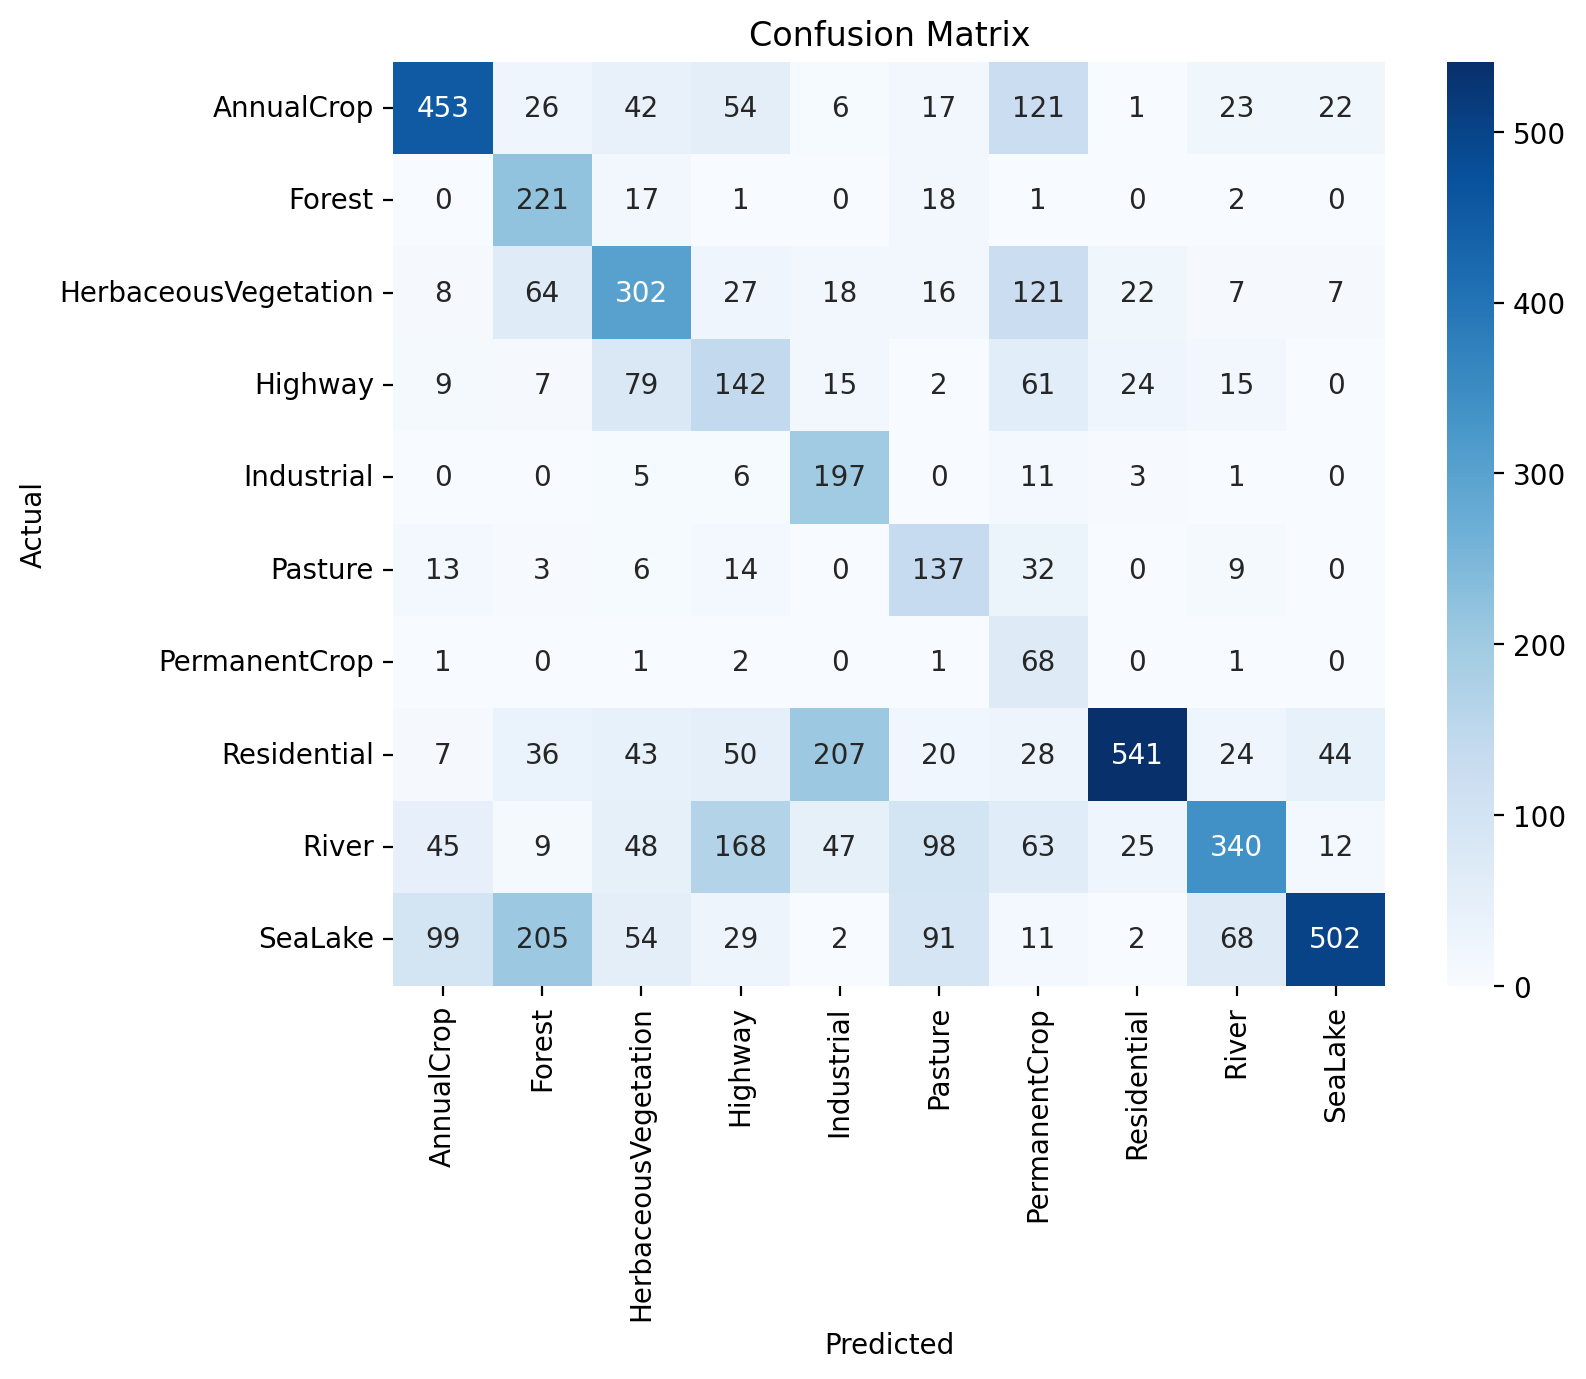

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65       765
           1       0.39      0.85      0.53       260
           2       0.51      0.51      0.51       592
           3       0.29      0.40      0.34       354
           4       0.40      0.88      0.55       223
           5       0.34      0.64      0.45       214
           6       0.13      0.92      0.23        74
           7       0.88      0.54      0.67      1000
           8       0.69      0.40      0.51       855
           9       0.86      0.47      0.61      1063

    accuracy                           0.54      5400
   macro avg       0.52      0.62      0.50      5400
weighted avg       0.67      0.54      0.56      5400



In [37]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [38]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [39]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

CustomMobileNetv2(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [40]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [41]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (mnet): Module(
    (features): Module(
      (0): Module(
        (0): ConvBn2d(
          3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
            fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.q

In [42]:
model_prepared = train(model_prepared,steps,print_every,epochs)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/5 |  Training Loss: 0.7800 |  Validation Loss: 0.9955 |  Validation Accuracy: 0.6781
Epoch: 1/5 |  Training Loss: 0.6218 |  Validation Loss: 0.6307 |  Validation Accuracy: 0.7807
Epoch: 1/5 |  Training Loss: 0.5700 |  Validation Loss: 0.5469 |  Validation Accuracy: 0.7993
Epoch: 1/5 |  Training Loss: 0.6209 |  Validation Loss: 0.6126 |  Validation Accuracy: 0.7859
Epoch: 1/5 |  Training Loss: 0.6090 |  Validation Loss: 0.5103 |  Validation Accuracy: 0.8104
Epoch: 1/5 |  Training Loss: 0.5598 |  Validation Loss: 0.4829 |  Validation Accuracy: 0.8300
Epoch: 1/5 |  Training Loss: 0.5931 |  Validation Loss: 0.5018 |  Validation Accuracy: 0.8244
Epoch: 1/5 |  Training Loss: 0.5098 |  Validation Loss: 0.4932 |  Validation Accuracy: 0.8311
Epoch: 1/5 |  Training Loss: 0.5576 |  Validation Loss: 0.5123 |  Validation Accuracy: 0.8226
Epoch: 1/5 |  Training Loss: 0.5694 |  Validation Loss: 0.5351 |  Validation Accuracy: 0.8178
Epoch: 1/5 |  Training Loss: 0.5041 |  Validation Loss: 0.48

In [43]:
model_prepared.to('cpu')

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0347]), zero_point=tensor([51], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.764017939567566, max_val=2.6399881839752197)
  )
  (mnet): Module(
    (features): Module(
      (0): Module(
        (0): ConvBn2d(
          3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
            fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([9.6501e-05, 1.5725e-02, 8.1762e-03, 1.7666e-02, 5.0973e-04, 8.6396e-04,
                    3.8022e-03, 8.3452e-04, 5.2823e-03, 1.6010e-05, 2.4263e-03, 3.6965e-04,


In [44]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [45]:
model_quantized_trained.to('cpu')

GraphModule(
  (mnet): Module(
    (features): Module(
      (0): Module(
        (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.06731679290533066, zero_point=30, padding=(1, 1))
        (2): ReLU6(inplace=True)
      )
      (1): Module(
        (conv): Module(
          (0): Module(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.21399728953838348, zero_point=62, padding=(1, 1), groups=32)
            (2): ReLU6(inplace=True)
          )
          (1): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.13244697451591492, zero_point=63)
        )
      )
      (2): Module(
        (conv): Module(
          (0): Module(
            (0): QuantizedConv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.08279213309288025, zero_point=51)
            (2): ReLU6(inplace=True)
          )
          (1): Module(
            (0): QuantizedConv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), scale=0.09172158688306808, zer

In [46]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  67.82008290290833
Accuracy achieved by the network on test images is: 82%


Confusion Matrix:


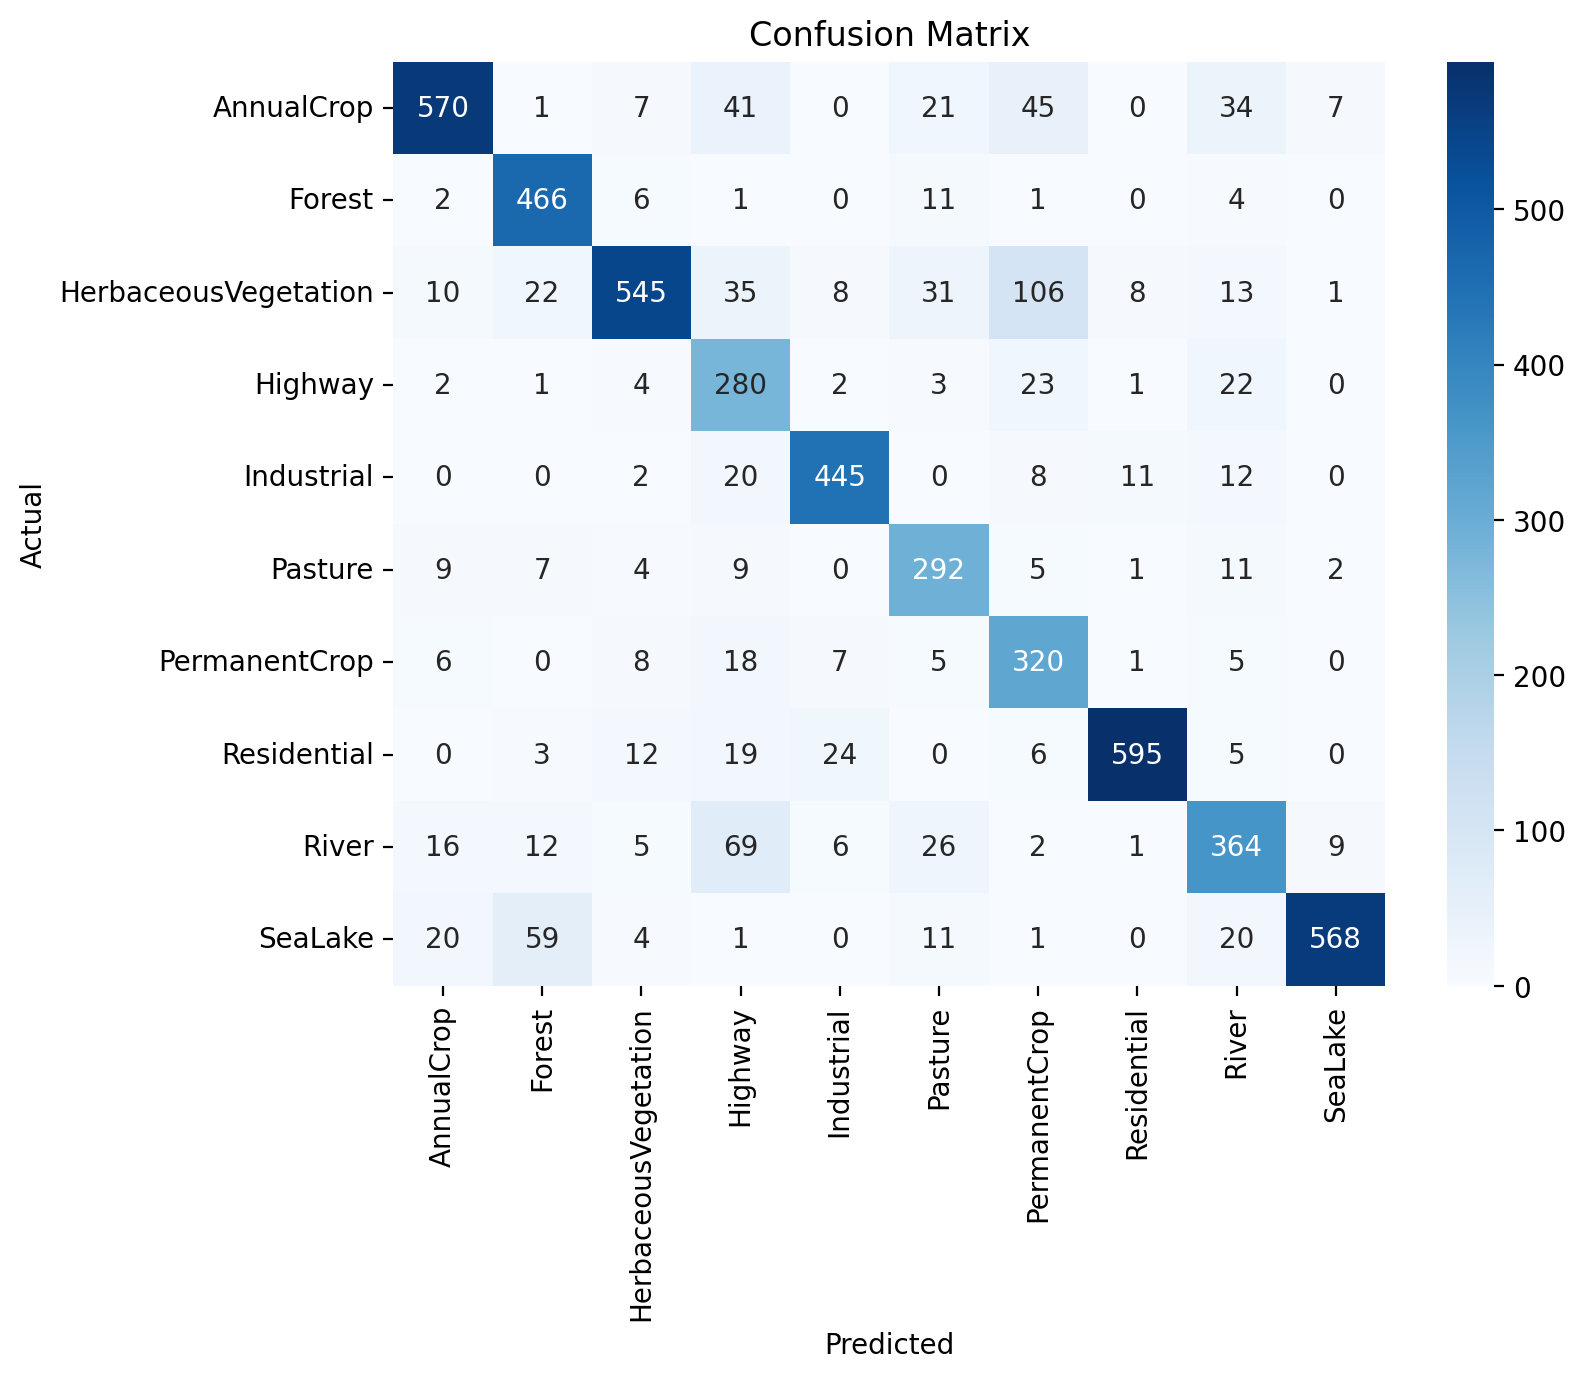

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       726
           1       0.82      0.95      0.88       491
           2       0.91      0.70      0.79       779
           3       0.57      0.83      0.67       338
           4       0.90      0.89      0.90       498
           5       0.73      0.86      0.79       340
           6       0.62      0.86      0.72       370
           7       0.96      0.90      0.93       664
           8       0.74      0.71      0.73       510
           9       0.97      0.83      0.89       684

    accuracy                           0.82      5400
   macro avg       0.81      0.83      0.81      5400
weighted avg       0.85      0.82      0.83      5400



In [47]:
metrics(all_predictions_int8,all_labels_int8)

In [48]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)

Size of fp16 model:8.31 MB
Size of PTQ model:4.53 MB
Size of QAT model:4.53 MB
